## Recitation 7
15.774 Fall 2020 <br>
Facility Location

## Load Packages

In [5]:
using JuMP, Gurobi, Random, PyPlot
const GRBENV = Gurobi.Env(); # Create a global gurobi environment to stop annoying academic messages.

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1192


Academic license - for non-commercial use only - expires 2022-09-06


In [6]:
Random.seed!(1542)
I = 20          # No. of customers
J = 5           # No. of possible warehouse locations
N = 3           # Maximum number of warehouses to open

# Generate random costs for opening a warehouse at each location
C = (10 .+ 10 .* rand(J)) * I / N 
@show C

# Generate random locations for each customer and potential warehouse.
Iloc = 100 * rand(I, 2)
Jloc = 100 * rand(J, 2)

# These represent (x/y) coordinates:
Jloc[1:5,:]

C = [102.063, 104.045, 69.9946, 119.854, 95.2058]


5×2 Array{Float64,2}:
 35.9645  33.5089
 52.8542  77.0353
 30.191   50.208 
 74.0378  65.603 
 11.0673  53.3858

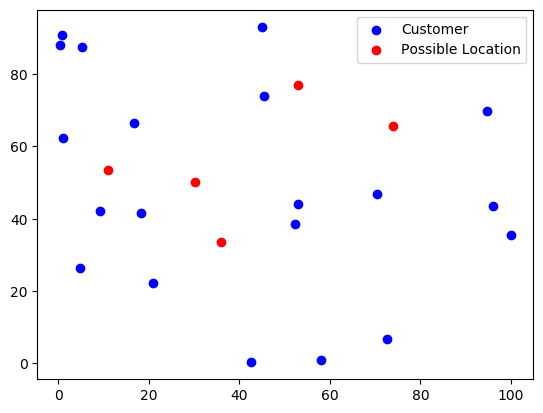

In [7]:
# Let's plot the locations:
scatter(Iloc[:,1], Iloc[:,2], color="blue")
scatter(Jloc[:,1], Jloc[:,2], color="red")
legend(["Customer", "Possible Location"]);

In [4]:
# We need c[i,j], the cost of servicing i from location j
# Let's just make them equal to the Euclidean distance between i and j:
c = zeros(I, J)
for i in 1:I
    for j in 1:J
        c[i,j] = sqrt((Iloc[i,1] - Jloc[j,1])^2 + (Iloc[i,2] - Jloc[j,2])^2)
    end
end

In [11]:
m = Model(() -> Gurobi.Optimizer(GRBENV))
set_optimizer_attribute(m, "OutputFlag", false)

# Binary variables: open warehouse at location j ∈ [1,...,J]?
@variable(m, z[1:J], Bin)

# Constraint: can't open more than 3 warehouses
@constraint(m, sum(z) <= N)

# Binary variables: assign customer i to warehouse J
@variable(m, x[1:I, 1:J], Bin)

# Constraint: Each customer should be assigned to exactly one warehouse
@constraint(m, [i=1:I], sum(x[i,:]) == 1)

# Costraint: Customers can't be assigned to warehouse j if J isn't open
@constraint(m, [j=1:J], sum(x[:,j]) <= I * z[j])

# Objective: Minimize fixed costs of opening plus transportation cost for each customer.
@objective(m, Min, sum(C .* z) + sum(c .* x))

# Solve and extract assignments
optimize!(m)


In [12]:
# Extract whether each location was opened
opened = value.(z) .== 1.0
@show opened
sum(opened)

opened = Bool[true, false, false, true, true]


3

In [13]:
# Extract whether a customer was assigned to location j
assign = value.(x) .== 1.0;
@show size(assign)

# Sum columns to get how many assigned to each location:
sum(assign, dims=1)

size(assign) = (20, 5)


1×5 Array{Int64,2}:
 6  0  0  6  8

In [9]:
println("Opening:   ", round(sum(C .* opened)))
println("Transport: ", round(sum(c .* assign)))
println("Total:     ", round(objective_value(m)))

Opening:   317.0
Transport: 545.0
Total:     862.0


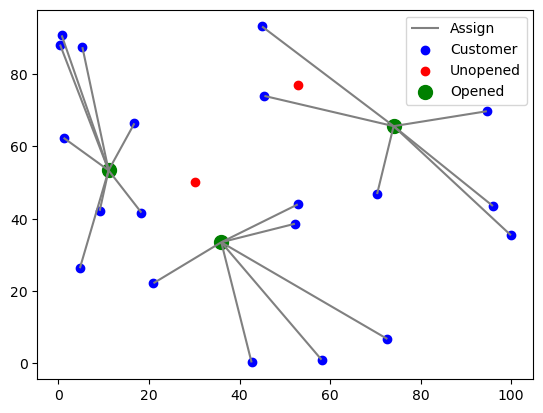

In [10]:
# Make a pretty plot of the assignment:
lines = Any[]
for i in 1:I, j in 1:J
    if assign[i,j]
        push!(lines, [Iloc[i,:], Jloc[j,:]])
    end
end
        
ax = PyPlot.axes()
line_segments = matplotlib.collections.LineCollection(lines, color="gray");
ax.add_collection(line_segments)
scatter(Iloc[:,1], Iloc[:,2], color="blue")
scatter(Jloc[.!opened,1], Jloc[.!opened,2], color="red")
scatter(Jloc[opened,1], Jloc[opened,2], color="green", s=100)
legend(["Assign", "Customer", "Unopened", "Opened"]);

Let's do the same exact model and plots, but now we don't need to cover all demand. We change the constraint so that some customers might not be covered, but we need to cover at least 90% of them. 

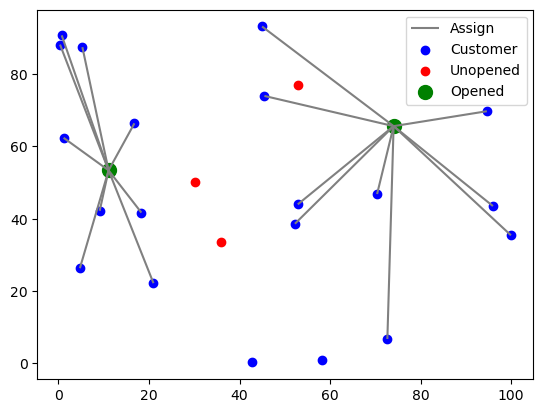

Opening:   215.0
Transport: 527.0
Total:     743.0


In [15]:
m = Model(() -> Gurobi.Optimizer(GRBENV))
set_optimizer_attribute(m, "OutputFlag", false)
@variable(m, z[1:J], Bin)
@constraint(m, sum(z) <= N)
@variable(m, x[1:I, 1:J], Bin)
@constraint(m, [i=1:I], sum(x[i,:]) <= 1) # Change so some customers not covered
@constraint(m, sum(x) >= 0.9 * I)         # Cover at least 90%
@constraint(m, [j=1:J], sum(x[:,j]) <= I * z[j])
@objective(m, Min, sum(C .* z) + sum(c .* x))
optimize!(m)

opened = value.(z) .== 1.0
assign = value.(x) .== 1.0;
println("Opening:   ", round(sum(C .* opened)))
println("Transport: ", round(sum(c .* assign)))
println("Total:     ", round(objective_value(m)))

lines = Any[]
for i in 1:I, j in 1:J
    if assign[i,j]
        push!(lines, [Iloc[i,:], Jloc[j,:]])
    end
end        
ax = PyPlot.axes()
line_segments = matplotlib.collections.LineCollection(lines, color="gray");
ax.add_collection(line_segments)
scatter(Iloc[:,1], Iloc[:,2], color="blue")
scatter(Jloc[.!opened,1], Jloc[.!opened,2], color="red")
scatter(Jloc[opened,1], Jloc[opened,2], color="green", s=100)
legend(["Assign", "Customer", "Unopened", "Opened"]);